In [ ]:
!pip install keras_tuner

In [1]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch

In [2]:
df = pd.read_csv('Real_Combine (1).csv')
df.head()

,T,TM,Tm,SLP,H,VV,V,VM,PM 2.5
0,7.4,9.8,4.8,1017.6,93.0,0.5,4.3,9.4,219.720833
1,7.8,12.7,4.4,1018.5,87.0,0.6,4.4,11.1,182.187500
2,6.7,13.4,2.4,1019.4,82.0,0.6,4.8,11.1,154.037500
3,8.6,15.5,3.3,1018.7,72.0,0.8,8.1,20.6,223.208333
4,12.4,20.9,4.4,1017.3,61.0,1.3,8.7,22.2,200.645833


In [3]:
df=df.dropna()
df.isnull().sum()

T         0
TM        0
Tm        0
SLP       0
H         0
VV        0
V         0
VM        0
PM 2.5    0
dtype: int64

In [4]:
# Creation of feature set and target set
x=df.iloc[:,:-1]
y=df.iloc[:,-1]

In [5]:
def hyper_tune(param):
    model = keras.Sequential()
    for i in range(param.Int('num_layers' ,2,20)):
        model.add(layers.Dense(units=param.Int('units_'+str(i),
                                              min_value=32,
                                              max_value=512,
                                              step=32),
                              activation='tanh'))
    model.add(layers.Dense(1,activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(param.Choice('learning_rate' , [1e-2 , 1e-3, 1e-4])),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error'])
    return model

In [6]:
tuner = RandomSearch(
    hyper_tune,
    objective='val_mean_absolute_error',
    max_trials=5,
    executions_per_trial=3,
    directory='project',
    overwrite=True,
    project_name = 'Air Quality Index AQI'
)

In [7]:
tuner.search_space_summary()   #skip

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [8]:
from sklearn.model_selection import train_test_split as tts
x_train,x_test,y_train,y_test = tts(x,y,test_size=0.3,random_state=0)

In [9]:
tuner.search(x_train , y_train , epochs=5, validation_data=(x_test,y_test))

Trial 5 Complete [00h 00m 16s]
val_mean_absolute_error: 75.38036092122395

Best val_mean_absolute_error So Far: 65.26177469889323
Total elapsed time: 00h 00m 49s
INFO:tensorflow:Oracle triggered exit


In [10]:
import matplotlib.pyplot as plt

#Get the best Hyperparameters found during the search
best_hps = tuner.get_best_hyperparameters(1)[0]

#Build the Model witht he best hyperparameters
model=hyper_tune(best_hps)

#Train the model with the best hyperparameters on the full training set
history = model.fit(x_train,y_train , epochs=5 ,validation_data = (x_test,y_test))



Epoch 1/5
24/24 [==============================] - 1s 8ms/step - loss: 97.3264 - mean_absolute_error: 97.3264 - val_loss: 82.4021 - val_mean_absolute_error: 82.4021
Epoch 2/5
24/24 [==============================] - 0s 3ms/step - loss: 84.5797 - mean_absolute_error: 84.5797 - val_loss: 73.0694 - val_mean_absolute_error: 73.0694
Epoch 3/5
24/24 [==============================] - 0s 3ms/step - loss: 76.3147 - mean_absolute_error: 76.3147 - val_loss: 68.6506 - val_mean_absolute_error: 68.6506
Epoch 4/5
24/24 [==============================] - 0s 3ms/step - loss: 71.9456 - mean_absolute_error: 71.9456 - val_loss: 66.3350 - val_mean_absolute_error: 66.3350
Epoch 5/5
24/24 [==============================] - 0s 3ms/step - loss: 69.4147 - mean_absolute_error: 69.4147 - val_loss: 65.3286 - val_mean_absolute_error: 65.3286


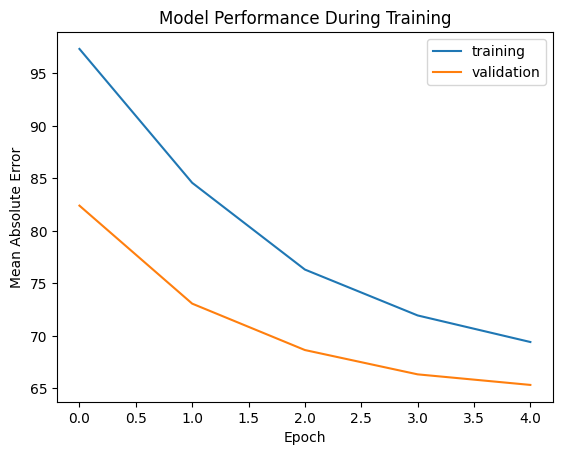

In [11]:
#Plot the Training and Validation Metrics for each Epoch
plt.plot(history.history['mean_absolute_error'] , label='training')
plt.plot(history.history['val_mean_absolute_error'] , label='validation')
plt.title('Model Performance During Training')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()